### Imports

In [95]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import peakutils
import os, glob
import data_tools as dt

### Directories

In [96]:
data_dir = os.path.join('./raw_data')
analysis_dir = os.path.join('./analysis')
fig_dir = os.path.join('./figures')

### Constants

Determined in `characterize_dot.ipynb`

In [97]:
MU_B = 5.7883818012e-5 # eV/T
K_B = 8.6173303e-5 # eV/K

ALPHA1_CLSD = 0.0469
ALPHA1_OPN = 0.0295
G1_OPN = 0.417
ALPHA2_CLSD = 0.0442
ALPHA2_OPN = 0.0333
G2_OPN = 0.400
ALPHA3_CLSD = 0.0415
ALPHA3_CLSD = 0.0265

# Calibrate Heater

Find conversion between applied power and dT using dataset 944. Here, a DC current ($I^{DC}_{Heat}$) was used to heat the reservoir.

<IPython.core.display.Javascript object>


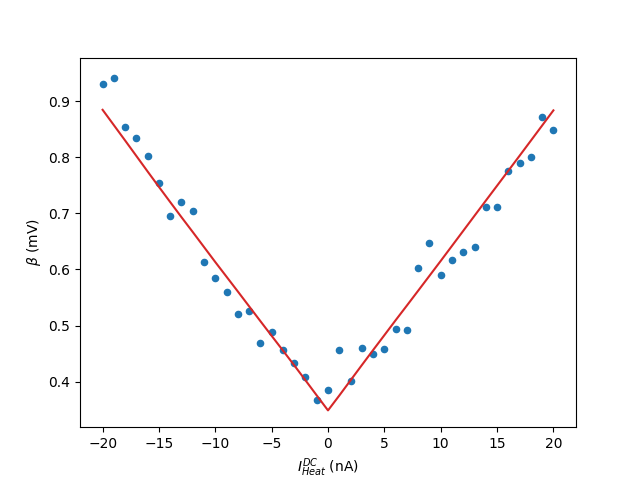

T_{base} (mK) = 94.8
\beta (mV) = 0.1884*\sqrt{P (pW)} + 0.3485


In [98]:
fig, ax = plt.subplots(1,1)

dat = 944
xmult = [0.5, 1e-3*2e-8] # plunger in mV, I_AC in Amps
avgs = 5

### import i_sense ###
swp = dt.open_hdf5(dat, path=data_dir) # load sweep data
x, z = dt.moving_avg(swp['x_array'][:]*xmult[0], swp['i_sense_dc2d'][:], 
                        avgs, axis=1) # rolling mean of sensor data
z = z*1e9 # i_sense (nA)
y = swp['y_array'][:]*xmult[1]*1e9 # I_AC (nA)

### fit i_sense curves ###
span = 5.0
xlim = (-490, -482)
centers = -486*np.ones(len(z))
widths = 0.6*np.ones(len(z))

i_results = dt.i_sense_fit_simultaneous(x, z, centers, widths, xlim, constrain = None, span = span)
i_results['i_heat'] = y

### calculate DC power ###
v = swp['vdc_heat2d'][:].mean(axis=1)
v = v-v[20] # subtract offset voltage
p = (i_results['i_heat'].values*1e-9)*v*1e12 # pW
i_results['p_heat'] = p

### fit beta vs sqrt(power) ###
popt = np.polyfit(np.sqrt(i_results['p_heat']), i_results['beta'], deg=1)
beta_calc = dt.line(np.sqrt(i_results['p_heat']), *popt)
t_calc = ALPHA1_CLSD*beta_calc/(2*K_B)
i_results['T_electron'] = t_calc

ax.scatter(i_results['i_heat'], i_results['beta'], s=20)
ax.plot(i_results['i_heat'], beta_calc, c='C3')
ax.set_xlabel(r'$I^{DC}_{Heat}$ (nA)')
ax.set_ylabel(r'$\beta$ (mV)')

print(r'T_{{base}} (mK) = {0:.1f}'.format(ALPHA1_CLSD*popt[1]/(2*K_B)))
print(r'\beta (mV) = {0:.4f}*\sqrt{{P (pW)}} + {1:.4f}'.format(*popt))

i_results.to_csv(os.path.join(analysis_dir,'dat944_i_results.csv'), index=False) # save

In [99]:
def power_to_beta(power):
    return 0.1884*np.sqrt(power) + 0.3485

# Fit 0-1 peak data

Fit dI curves to fit for dS at the 0-1 electron transition. 

dataset 945 -- di vs plunger vs AC power  
dataset 1011 -- di vs plunger vs parallel field

<IPython.core.display.Javascript object>


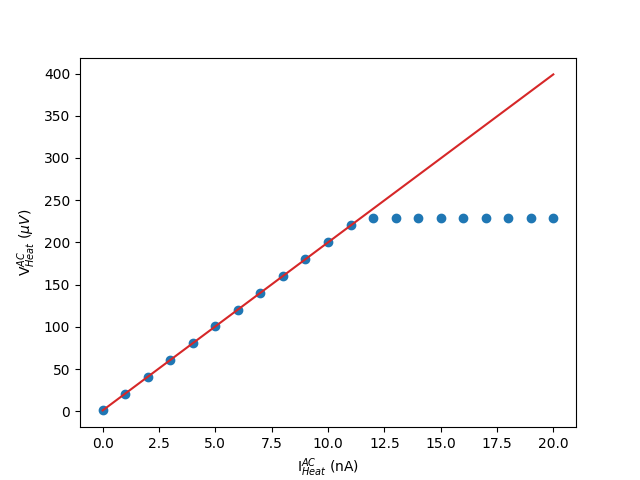

In [100]:
# calculate applied AC power
# lock in measuring v_heat overloaded, so I need to clean up the data
dat = 945
xmult = [0.5, 2e-8] # plunger in mV, I_ac in Amps

swp = dt.open_hdf5(dat, path=data_dir) # load sweep data
v = swp['vac_heat2d'][:].mean(axis=1)*1e6
y = swp['y_array'][:]*xmult[1]*1e9

fig, ax = plt.subplots(1,1)

ax.scatter(y, v)
ax.set_xlabel('I$^{AC}_{Heat}$ (nA)')
ax.set_ylabel('V$^{AC}_{Heat}$ ($\mu V$)')

popt = np.polyfit(y[:12], v[:12], deg=1)
v_corrected = dt.line(y, *popt)
ax.plot(y, v_corrected, c='C3')

p = v_corrected*y*1e-3
t_calc = ALPHA1_CLSD*power_to_beta(p)/(2*K_B)

di_results = pd.DataFrame({'i_heat':y, 'v_heat':v_corrected, 'p_heat':p, 't_calc':t_calc, 'dT':t_calc-t_calc[0]})

In [101]:
# fit dataset 945 twice
#    first with delta=0, second with delta as a free parameter

avgs = 5
span = 5.0

x, z = dt.moving_avg(swp['x_array'][:]*xmult[0], swp['g5x2d'][:], avgs, axis=1)
z = z*(1e-8)*(1e9)  # convert from dV to dI (nA)

xlim = (-490, -486)
centers = -488*np.ones(len(z))
widths = 0.6*np.ones(len(z))

di_zero_params = dt.di_fit_simultaneous(x, z, centers, widths, xlim, constrain = None, span = span, fix=['delta'])
di_free_params = dt.di_fit_simultaneous(x, z, centers, widths, xlim, constrain = None, span = span)

pd.concat([di_results, di_zero_params], axis=1).to_csv(
    os.path.join(analysis_dir,'dat945_di_zero_fits.csv'), index=False)
pd.concat([di_results, di_free_params], axis=1).to_csv(
    os.path.join(analysis_dir,'dat945_di_free_fits.csv'), index=False)

In [102]:
# equation for change in entropy at 0-1 electron transition

def dS01(fields, a, b, g, de):
    return dt.gibbs_entropy(fields, a, b, 100.0, g, de) - 0

<IPython.core.display.Javascript object>


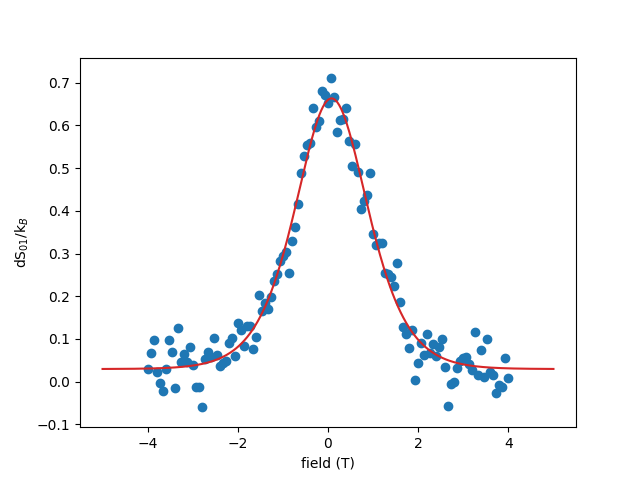

In [103]:
dat = 1011
xmult = [0.5, 1.0] # mV, mT
swp = dt.open_hdf5(dat, path=data_dir) # load sweep data

avgs = 5
span = 5.0

fig, ax = plt.subplots(1,1)

### get centers from g_sense ###
x, z = dt.moving_avg(swp['x_array'][:]*xmult[0], swp['g_sense_dc2d'][:], avgs, axis=1)
y = swp['y_array'][:]
dz = dt.dfdx(z, x, axis = 1)
argmins = np.argmin(dz, axis=1)
realmins = x[argmins]
centers_fit = np.polyfit(y, realmins, deg=2)
centers = dt.parabola(y,*centers_fit)

### plot dI ###
x, z = dt.moving_avg(swp['x_array'][:]*xmult[0], swp['g5x2d'][:], avgs, axis=1)
z = z*(1e-8)*(1e9) # nA

results = dt.di_fit_simultaneous(x, z, centers, 0.65*np.ones(len(z)), 
                                        (-495,-485), constrain = None, span=span)
results['field'] = y/1000.0

p0 = (0.7, 0.0, 0.4, 0.0)
bounds = ([0.1, -0.2, 0.1, -0.2], [1.4, 0.2, 1.0, 0.2])
popt, pcov = dt.curve_fit(dS01, 1000*results['field'].values, -2.0*results['delta'].values, p0=p0, bounds=bounds)
bs = np.linspace(-5, 5, 500)

ax.scatter(results['field'], -2.0*results['delta'])
ax.plot(bs, dS01(1000*bs, *popt), c='C3')
ax.set_xlabel('field (T)');
ax.set_ylabel(r'dS$_{01}$/k$_{B}$');

### save data ###
results.to_csv(os.path.join(analysis_dir,'dat1011_di_free_fits.csv'), index=False)
np.savetxt(os.path.join(analysis_dir, "dat1011_field.csv"), bs, delimiter=",")
np.savetxt(os.path.join(analysis_dir, "dat1011_dS01_fit.csv"), dS01(1000*bs, *popt), delimiter=",")

# Fit 2-3 peak data

Fit dI curves to fit for dS at the 2-3 electron transition. Here, the entropy of the ST states is ignored because the field is not high enough for those states to contribute to dS

dataset 1442 -- di vs plunger vs parallel field

In [104]:
# equation for change in entropy at 0-1 electron transition

def dS23(fields, a, b, g, de):
    return dt.gibbs_entropy(fields, a, b, 100.0, g, de) - 0

<IPython.core.display.Javascript object>


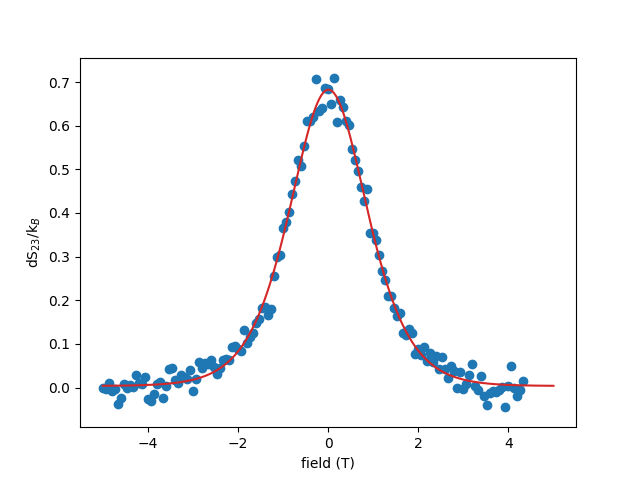

In [105]:
dat = 1442
xmult = [0.5, 1.0] # mV, mT
n=-10
swp = dt.open_hdf5(dat, path=data_dir) # load sweep data

avgs = 5
span = 5.0

fig, ax = plt.subplots(1,1)

### get centers from g_sense ###
x, z = dt.moving_avg(swp['x_array'][:]*xmult[0], swp['g_sense_dc2d'][:n], avgs, axis=1)
y = swp['y_array'][:n]
dz = dt.dfdx(z, x, axis = 1)
argmins = np.argmin(dz, axis=1)
realmins = x[argmins]
centers_fit = np.polyfit(y, realmins, deg=2)
centers = dt.parabola(y,*centers_fit)

### plot dI ###
x, z = dt.moving_avg(swp['x_array'][:]*xmult[0], swp['g5x2d'][:n], avgs, axis=1)
z = z*(1e-8)*(1e9) # nA

results = dt.di_fit_simultaneous(x, -1*z, centers, 0.65*np.ones(len(z)), 
                                        (-327,-313), constrain = None, span=span)
results['field'] = y/1000.0

p0 = (0.7, 0.0, 0.4, 0.0)
bounds = ([0.1, -0.2, 0.1, -0.2], [1.4, 0.2, 1.0, 0.2])
popt, pcov = dt.curve_fit(dS23, 1000*results['field'].values, -2.0*results['delta'].values, p0=p0, bounds=bounds)
bs = np.linspace(-5, 5, 500)

ax.scatter(results['field'], -2.0*results['delta'])
ax.plot(bs, dS23(1000*bs, *popt), c='C3')
ax.set_xlabel('field (T)');
ax.set_ylabel(r'dS$_{23}$/k$_{B}$');

### save data ###
results.to_csv(os.path.join(analysis_dir,'dat1442_di_free_fits.csv'), index=False)
np.savetxt(os.path.join(analysis_dir, "dat1442_field.csv"), bs, delimiter=",")
np.savetxt(os.path.join(analysis_dir, "dat1442_dS23_fit.csv"), dS01(1000*bs, *popt), delimiter=",")

# Fit 1-2 peak data

Fit dI curves to fit for dS at the 1-2 electron transition.

dataset 1284,1285,1286,1288,1290 -- di vs plunger vs parallel field (field increases with dataset number)

In [106]:
def dS12(fields, alow, ahigh, b, glow, ghigh, de, est):
    return dt.gibbs_entropy(fields, alow, 0.0, 100, glow, est) - \
             dt.gibbs_entropy(fields, ahigh, 0.0, 100, ghigh, de) + b

In [108]:
xmult = [0.5, 1.0] # mV, mT
avgs = 5
span = 5.0

fig, ax = plt.subplots(1,1)

#############
dats = [1284, 1285, 1286, 1288, 1290]
ns = [None, None, 25, None, None]

columns = ['x0', 'beta', 'di0', 'di2', 'delta', 'field']
di_results = pd.DataFrame(columns=columns)

for n, dat in zip(ns,dats):
    swp = dt.open_hdf5(dat, path=data_dir) # load sweep data
    
    ### get centers from g_sense ###
    x, z = dt.moving_avg(swp['x_array'][:]*xmult[0], swp['g_sense_dc2d'][:n], avgs, axis=1)
    y = swp['y_array'][:n]
    dz = dt.dfdx(z, x, axis = 1)
    argmins = np.argmin(dz, axis=1)
    realmins = x[argmins]
    centers_fit = np.polyfit(y, realmins, deg=2)
    centers = dt.parabola(y,*centers_fit)

    ### plot dI ###
    x, z = dt.moving_avg(swp['x_array'][:]*xmult[0], swp['g5x2d'][:n], avgs, axis=1)
    z = z*(1e-8)*(1e9) # nA

    _results = dt.di_fit_simultaneous(x, -1*z, centers, 0.65*np.ones(len(z)), 
                                            (-305,-265), constrain = None, span=span)
    _results['field'] = y/1000.0
    di_results = pd.concat([di_results, _results], ignore_index=True)

### fit entropy ###
p0 = (1.0, 1.0, 0.0, 0.4, 0.4, 0.0, 0.25)
bounds = ([0.1, 0.1, -0.2, 0.1, 0.1, -0.2, 0.1], [1.4, 1.4, 0.2, 0.8, 0.8, 0.2, 0.5]) # limits
popt, pcov = dt.curve_fit(dS12, 1000*di_results['field'].values, -2.0*di_results['delta'].values, 
                              p0=p0, bounds=bounds)
bs = np.linspace(-4, 10, 500)

ax.scatter(di_results['field'], -2.0*di_results['delta'], c='C0', s=10)
ax.plot(bs, dS12(1000*bs, *popt), c='C3', ls='--')
ax.set_xlabel('field (T)');
ax.set_ylabel('dS$_{12}$/k$_{B}$');

### save data ###
results.to_csv(os.path.join(analysis_dir,'dat1284-1290_di_free_fits.csv'), index=False)
np.savetxt(os.path.join(analysis_dir, "dat1284-1290_field.csv"), bs, delimiter=",")
np.savetxt(os.path.join(analysis_dir, "dat1284-1290_dS12_fit.csv"), dS12(1000*bs, *popt), delimiter=",")

<IPython.core.display.Javascript object>